In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from typing import List, Dict

In [2]:
os.getcwd()

'/home/ethan/02750-automation/automation_final_project/results'

In [3]:
results_directory_list = os.listdir()
print(len(results_directory_list))
results_directory_list[:3]

153


['logd74_randomforest_random_32.npy',
 'results_abalone_age.png',
 'abalone_age_randomforest_hierarchical_16.npy']

# get x axis for each dataset

In [4]:
all_dataset_names = ['abalone_age','Inhibition_data','logd74']
dataset_sizes = [4177, 454, 1130]

x_axis_dict = {}
for idx_dataset, dataset_name in enumerate(all_dataset_names):
    size = dataset_sizes[idx_dataset]
    if dataset_name == 'Inhibition_data':
        x_axis_dict[dataset_name] = {}
        for batch_size in [4, 8]:
            x_train_length = size*0.8
            twenty_percent = int(x_train_length * 0.20)
            fifty_percent = int(x_train_length * 0.5)
            num_samples_axis = range(twenty_percent,fifty_percent+1,batch_size)
            x_axis_dict[dataset_name][batch_size] = range(twenty_percent,fifty_percent+1,batch_size)
    else:
        x_axis_dict[dataset_name] = {}
        for batch_size in [16, 32]:
            x_train_length = size*0.8
            twenty_percent = int(x_train_length * 0.20)
            fifty_percent = int(x_train_length * 0.5)
            num_samples_axis = range(twenty_percent,fifty_percent+1,batch_size)
            x_axis_dict[dataset_name][batch_size] = range(twenty_percent,fifty_percent+1,batch_size)

In [5]:
x_axis_dict

{'abalone_age': {16: range(668, 1671, 16), 32: range(668, 1671, 32)},
 'Inhibition_data': {4: range(72, 182, 4), 8: range(72, 182, 8)},
 'logd74': {16: range(180, 453, 16), 32: range(180, 453, 32)}}

# plotting code

In [6]:
dict_abbreviation_to_name: Dict[str,str] = {'palice': 'P-ALICE','covdrop': 'CovDrop','random':'Random','uncertainty':'Uncertainty','UC':'Uncertainty','randomforest':'Random Forest','k-means':'K-Means','nn':'MLP','hierarchical':'Hierarchical', 'abalone_age': 'Abalone Age', 'Inhibition_data': 'Kinase Inhibition', 'logd74':'Lipophilicity of Small Molecules','linear':'Linear','nonlinear':'Nonlinear'}
base_learner_order_to_process = ['nonlinear','linear','randomforest','nn']
dict_base_learner_to_color = {'nonlinear': 'r', 'linear':'m', 'randomforest':'g','nn':'b'}
dict_active_method_to_styles = {'palice':'o--','covdrop':'o:','random':'o-','uncertainty':'o-.', 'UC':'o-.', 'k-means':'o--', 'hierarchical':'o-.'}
# dict_active_method_to_styles = {'palice':'P--','covdrop':'*:','random':'o-','uncertainty':'^-.', 'UC':'^-.', 'k-means':'s--', 'hierarchical':'p--'}

In [7]:
MAX_MARKER_SIZE = 2000
MIN_MARKER_SIZE = 50
FIG_SIZE = (50,25)
def plot_results_for_dataset(target_dataset_name:str, results_directory_list:List[str],x_axis_dict,regular_print:bool=True):
    desired_results = []

    all_avg_cor = []
    for result_file in results_directory_list:
        if regular_print == True and "Inhibition" in target_dataset_name:
            if "V2" not in result_file and "linear" in result_file:
                continue
        elif regular_print == False and "Inhibition" in target_dataset_name:
            if "V2" in result_file and "linear" in result_file:
                continue
            elif "linear" not in result_file:
                continue

        if result_file[-4:] != '.npy' or result_file[:len(target_dataset_name)] != target_dataset_name:
            continue # skip, we are not interested in this file
        if result_file[-7:] == 'cor.npy': # and "V2" not in result_file:
            # print(result_file)
            avg_cors = np.mean(np.load(result_file),axis=0)
            # if np.max(avg_cors) > 1.0:
            #     print('^ABOVE FILE HAD GREATER THAN ONE PEARSON')
            all_avg_cor.extend(avg_cors.tolist())
        # elif result_file[-7:] == 'cor.npy' and "V2" in result_file:
        #     print(result_file)
        #     avg_cors = np.mean(np.load(result_file),axis=0)
        #     # if np.max(avg_cors) > 1.0:
        #     #     print('^ABOVE FILE HAD GREATER THAN ONE PEARSON')
        #     all_avg_cor.extend(avg_cors.tolist())

        if result_file[-7:] != 'cor.npy':  
            desired_results.append(result_file)

    all_avg_cor = np.array(all_avg_cor)
    max_cor = np.max(all_avg_cor)
    min_cor = np.min(all_avg_cor)

    # print(f"target_dataset_name={target_dataset_name},max_cor={max_cor},min_cor={min_cor}, get_marker_sizes(max_cor)={get_marker_sizes_v2(max_cor,min_cor)},get_marker_sizes(min_cor)={get_marker_sizes_v2(min_cor,min_cor)}, ")
    # print(f"desired_results={desired_results}")
    error_in_length = []
    plt.rcParams.update({'font.size': 30})  # Change the font size as desired
    fig, ax = plt.subplots(figsize=FIG_SIZE)
        
    for base_learner in base_learner_order_to_process:
        for result_file in desired_results:
            if base_learner not in result_file:
                continue # skip this file
            if base_learner == "linear" and "non" in result_file:
                continue # so base_learner=linear_palice AND abalone_age_nonlinear_palice_32.npy dont go together
            
            if target_dataset_name == 'Inhibition_data' or target_dataset_name == 'abalone_age':
                _, _, base_learner_name, active_method_name, batch_size = result_file.split('_')
            else:
                _, base_learner_name, active_method_name, batch_size = result_file.split('_')
            batch_size = batch_size.split('.')[0]

            if batch_size != '32' and batch_size != '8':
                # print(f"THIS WAS batch_size={batch_size}")
                continue # skip this file, we only want the largest batch sizes
            else:
                good_batch_size = batch_size

            # if regular_print == True:
            #     # want to use V2 of linear/nonlinear
            #     if "linear" in result_file and "V2" not in result_file:
            #         print(result_file)
            #         continue
            # else:
            #     if "V2" in result_file  and ("linear" in base_learner):
            #         continue # we are doing a special plot, skip the other datasets
            
            
            result_array = np.load(result_file)
            means = np.mean(result_array,axis=0)
            # print(f"HERE result_file={result_file}\nmeans[0:10]={means}")
            stds = np.std(result_array,axis=0)
            x_axis = x_axis_dict[target_dataset_name][int(batch_size)]

            # if "linear" in result_file or "nn" in result_file:
            cor_vals_file = result_file[:-4] + '_cor.npy'
            cor_vals = np.load(cor_vals_file)
            mean_cor_vals = np.mean(cor_vals,axis=0)

            if len(base_learner_name) > len(base_learner):
                version = '-V' + base_learner_name[-1]
                base_learner_name = base_learner
            else:
                version = ''
            label = dict_abbreviation_to_name[base_learner_name] + version + ', ' + dict_abbreviation_to_name[active_method_name]
            # print(f"base_learner={base_learner}",result_file, f"label={label}. batch_size={batch_size}")

            # print(f"len(x_axis)={len(x_axis)}, means.shape[0]={means.shape[0]}, label={label}")
            if len(x_axis) > means.shape[0]:
                x_axis = x_axis[:means.shape[0]]
                # print(f" modified length, len(x_axis) = {len(x_axis)}")
                error_in_length.append(result_file)
            elif len(x_axis) < means.shape[0]:
                means_copy = means.tolist()
                stds_copy = stds.tolist()
                means = means_copy[:len(x_axis)]
                stds = stds_copy[:len(x_axis)]
                error_in_length.append(result_file)
                # print(f" modified length, len(means) = {len(means)}")
            
            if regular_print == False: 
                stds = stds*0.5
            
            fmt_string = dict_base_learner_to_color[base_learner_name] + dict_active_method_to_styles[active_method_name]
    
            # plt.errorbar(x=x_axis,y=means, yerr=stds, fmt=fmt_string, capsize=10, markersize=0, label=label)
            plt.errorbar(x=x_axis,y=means, yerr=stds, fmt=fmt_string, capsize=10, markersize=0, label=label)

            # if "linear" in result_file or "nn" in result_file:
            c = dict_base_learner_to_color[base_learner_name]
            marker = dict_active_method_to_styles[active_method_name][0]
            # marker_sizes = get_marker_sizes_v1(mean_cor_vals)
            marker_sizes = get_marker_sizes_v2(mean_cor_vals,min_cor)
                # raise Exception(f'result_file={result_file}, marker_sizes={marker_sizes}')
            ax.scatter(x=x_axis,y=means,c=c,marker=marker,s=marker_sizes,alpha=0.5)


    # customize plot
    ax.set_xlabel('Number of Labeled Samples [-]')
    ax.set_ylabel('Test MSE')
    s_max = get_marker_sizes_v2(max_cor,min_cor)
    s_min = get_marker_sizes_v2(min_cor,min_cor)
    ax.scatter([], [],c='black', s=s_max, label=f'Max Marker, r={max_cor}',alpha=0.25)
    ax.scatter([], [],c='black', s=s_min, label=f'Min Marker, r={min_cor}',alpha=0.25)
    ax.legend(loc='upper left', bbox_to_anchor=(1.025, 0.75), shadow=True, ncol=1) # legend to right
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=1) # legend below

    ax.set_title(dict_abbreviation_to_name[target_dataset_name] + f'\nBatch Size = {good_batch_size}')
    ax.grid(True)

    # Specify the file path and format
    file_path = "results_" + target_dataset_name + '.png'  # File path where you want to save the plot
    file_format = 'png'  # File format (e.g., 'png', 'pdf', 'svg')

    
    if regular_print == False:
        file_path = "results_" + target_dataset_name + '_V1.png'  # File path where you want to save the plot
        ax.set_yscale('log')
        ax.set_ylim((10**-3,10**12))
        ax.set_title(dict_abbreviation_to_name[target_dataset_name] + f'\nBatch Size = {good_batch_size}\nError Bars 50%')
    elif "Inhibition" in target_dataset_name and regular_print == True:
        file_path = "results_" + target_dataset_name + '_V2.png'  # File path where you want to save the plot

    # Set the DPI (dots per inch) for high-quality output
    dpi = 250  # You can adjust this value for your desired resolution
    plt.tight_layout() # allows matplotlib to save the legend without cutting off a portion
    
    # Save the plot with high quality
    plt.savefig(file_path, format=file_format, dpi=dpi)

    plt.show()
    return error_in_length

def get_marker_sizes_v1(cor_vals:np.ndarray)->np.ndarray:
    """cor_vals are all between -1,1. so simply let -1 be smallest marker and +1 be largest marker"""
    return MAX_MARKER_SIZE*(cor_vals+1)/2

def get_marker_sizes_v2(cor_vals:np.ndarray, min_cor_val:float |np.float_, scaling_factor:int = 1000)->np.ndarray:
    """ let the min marker size be the minimum cor val."""
    return (cor_vals - min_cor_val)*(scaling_factor) + MIN_MARKER_SIZE

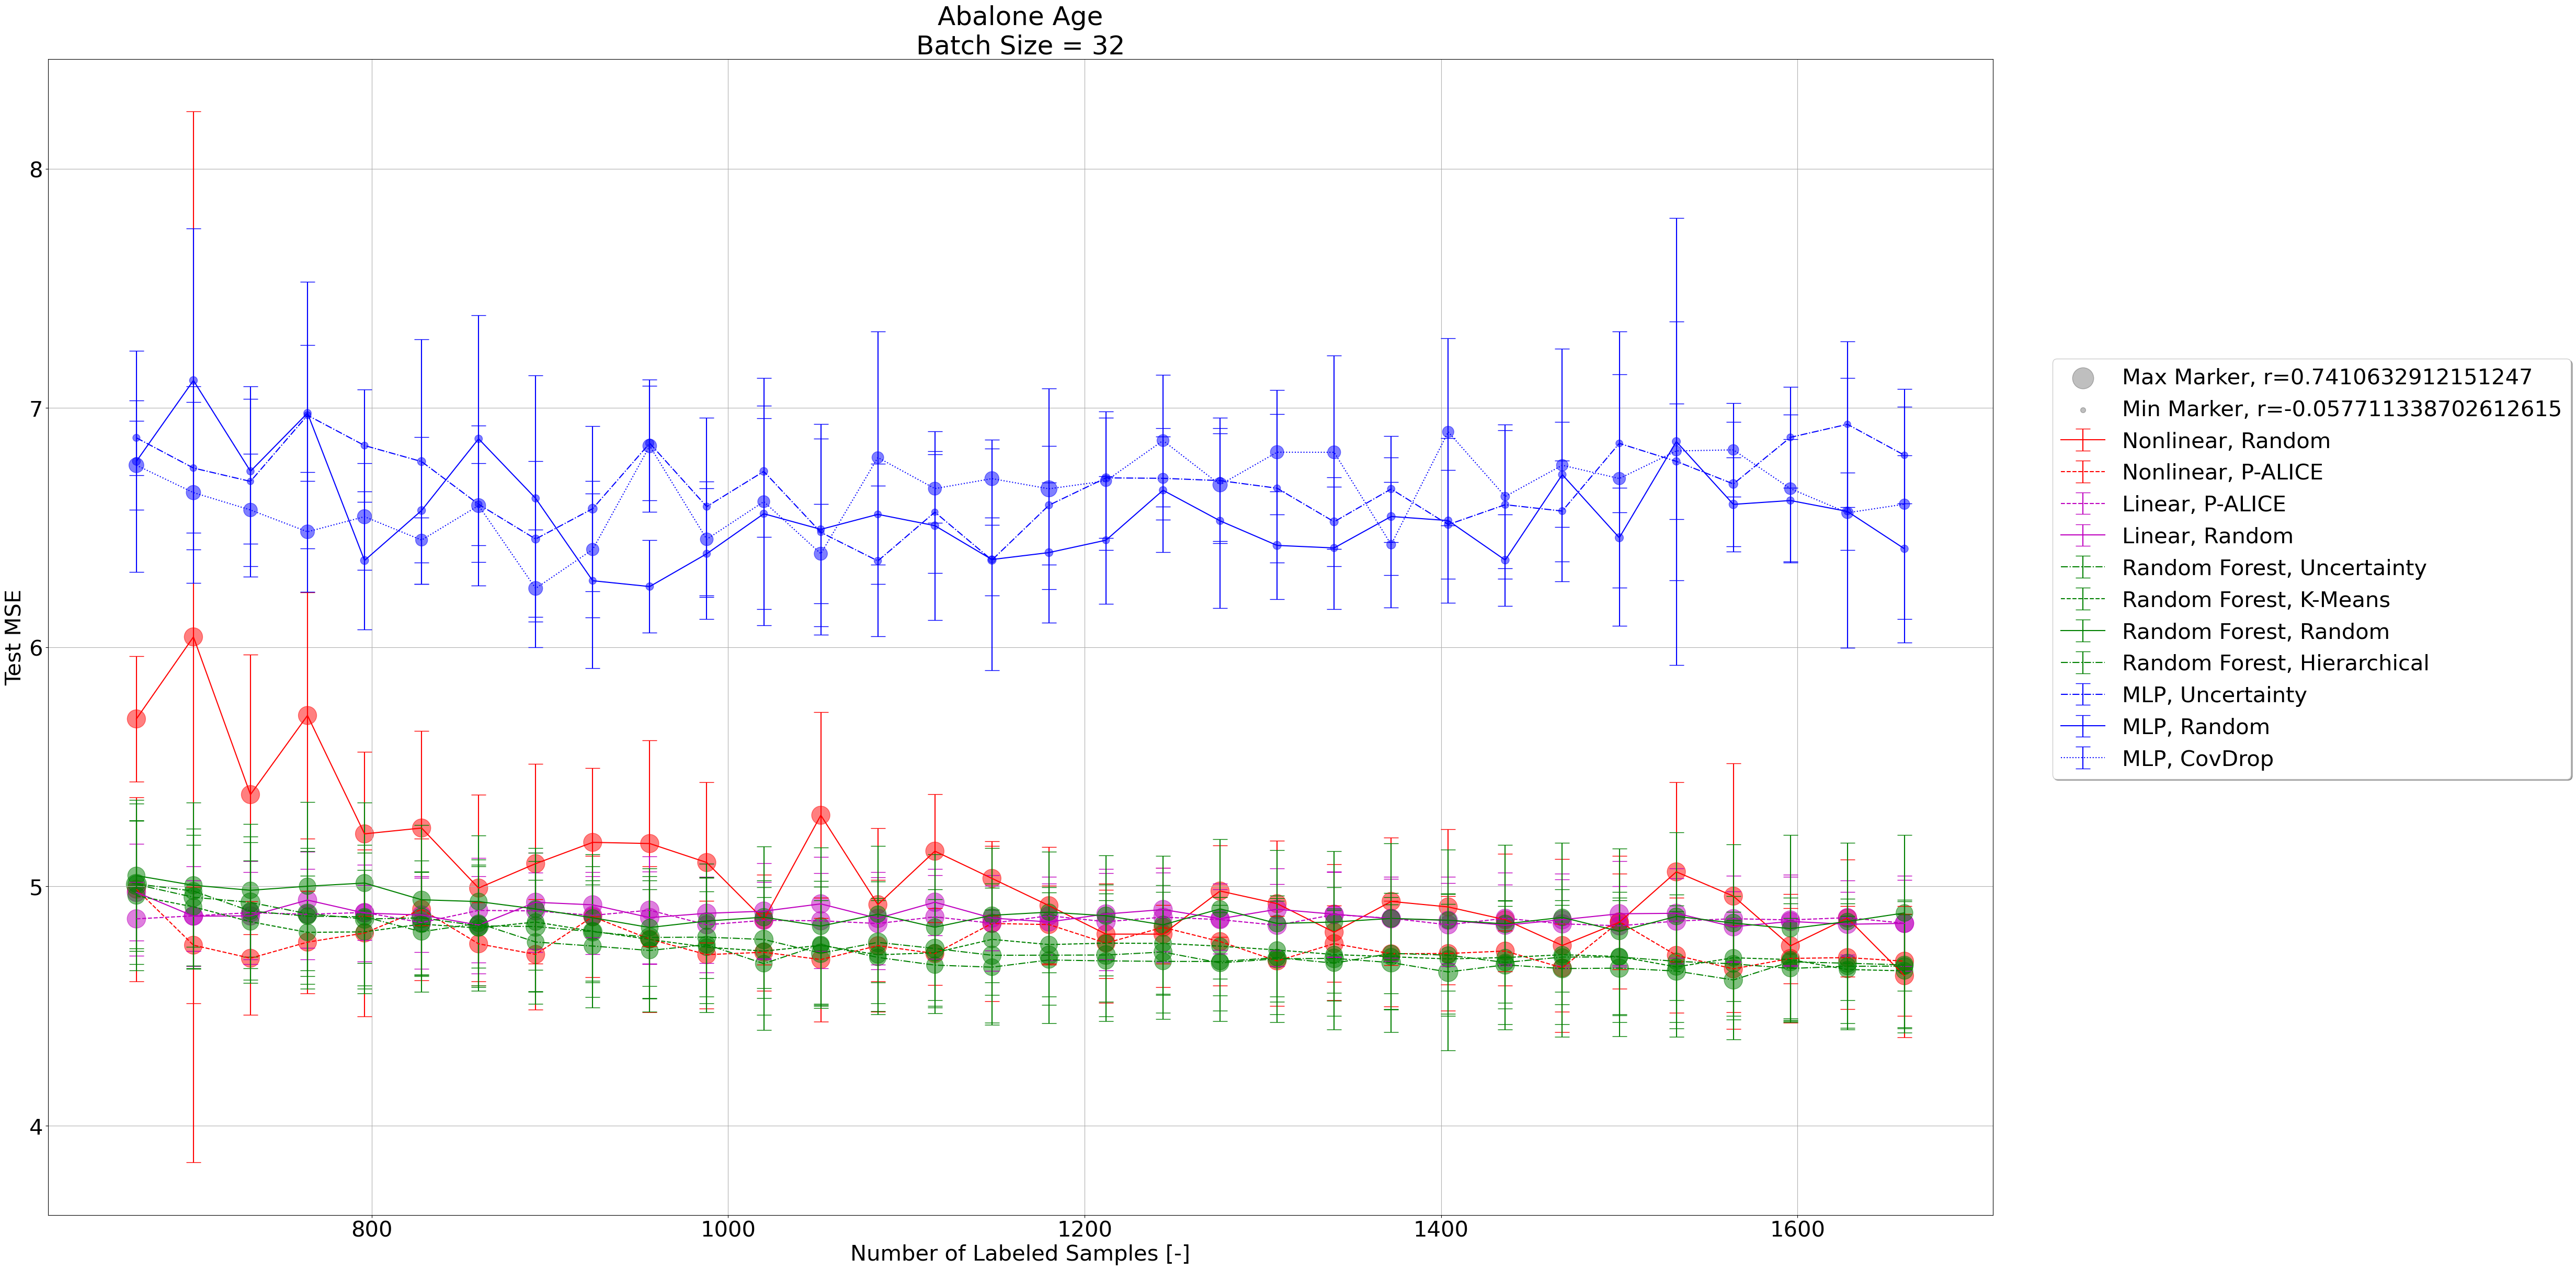

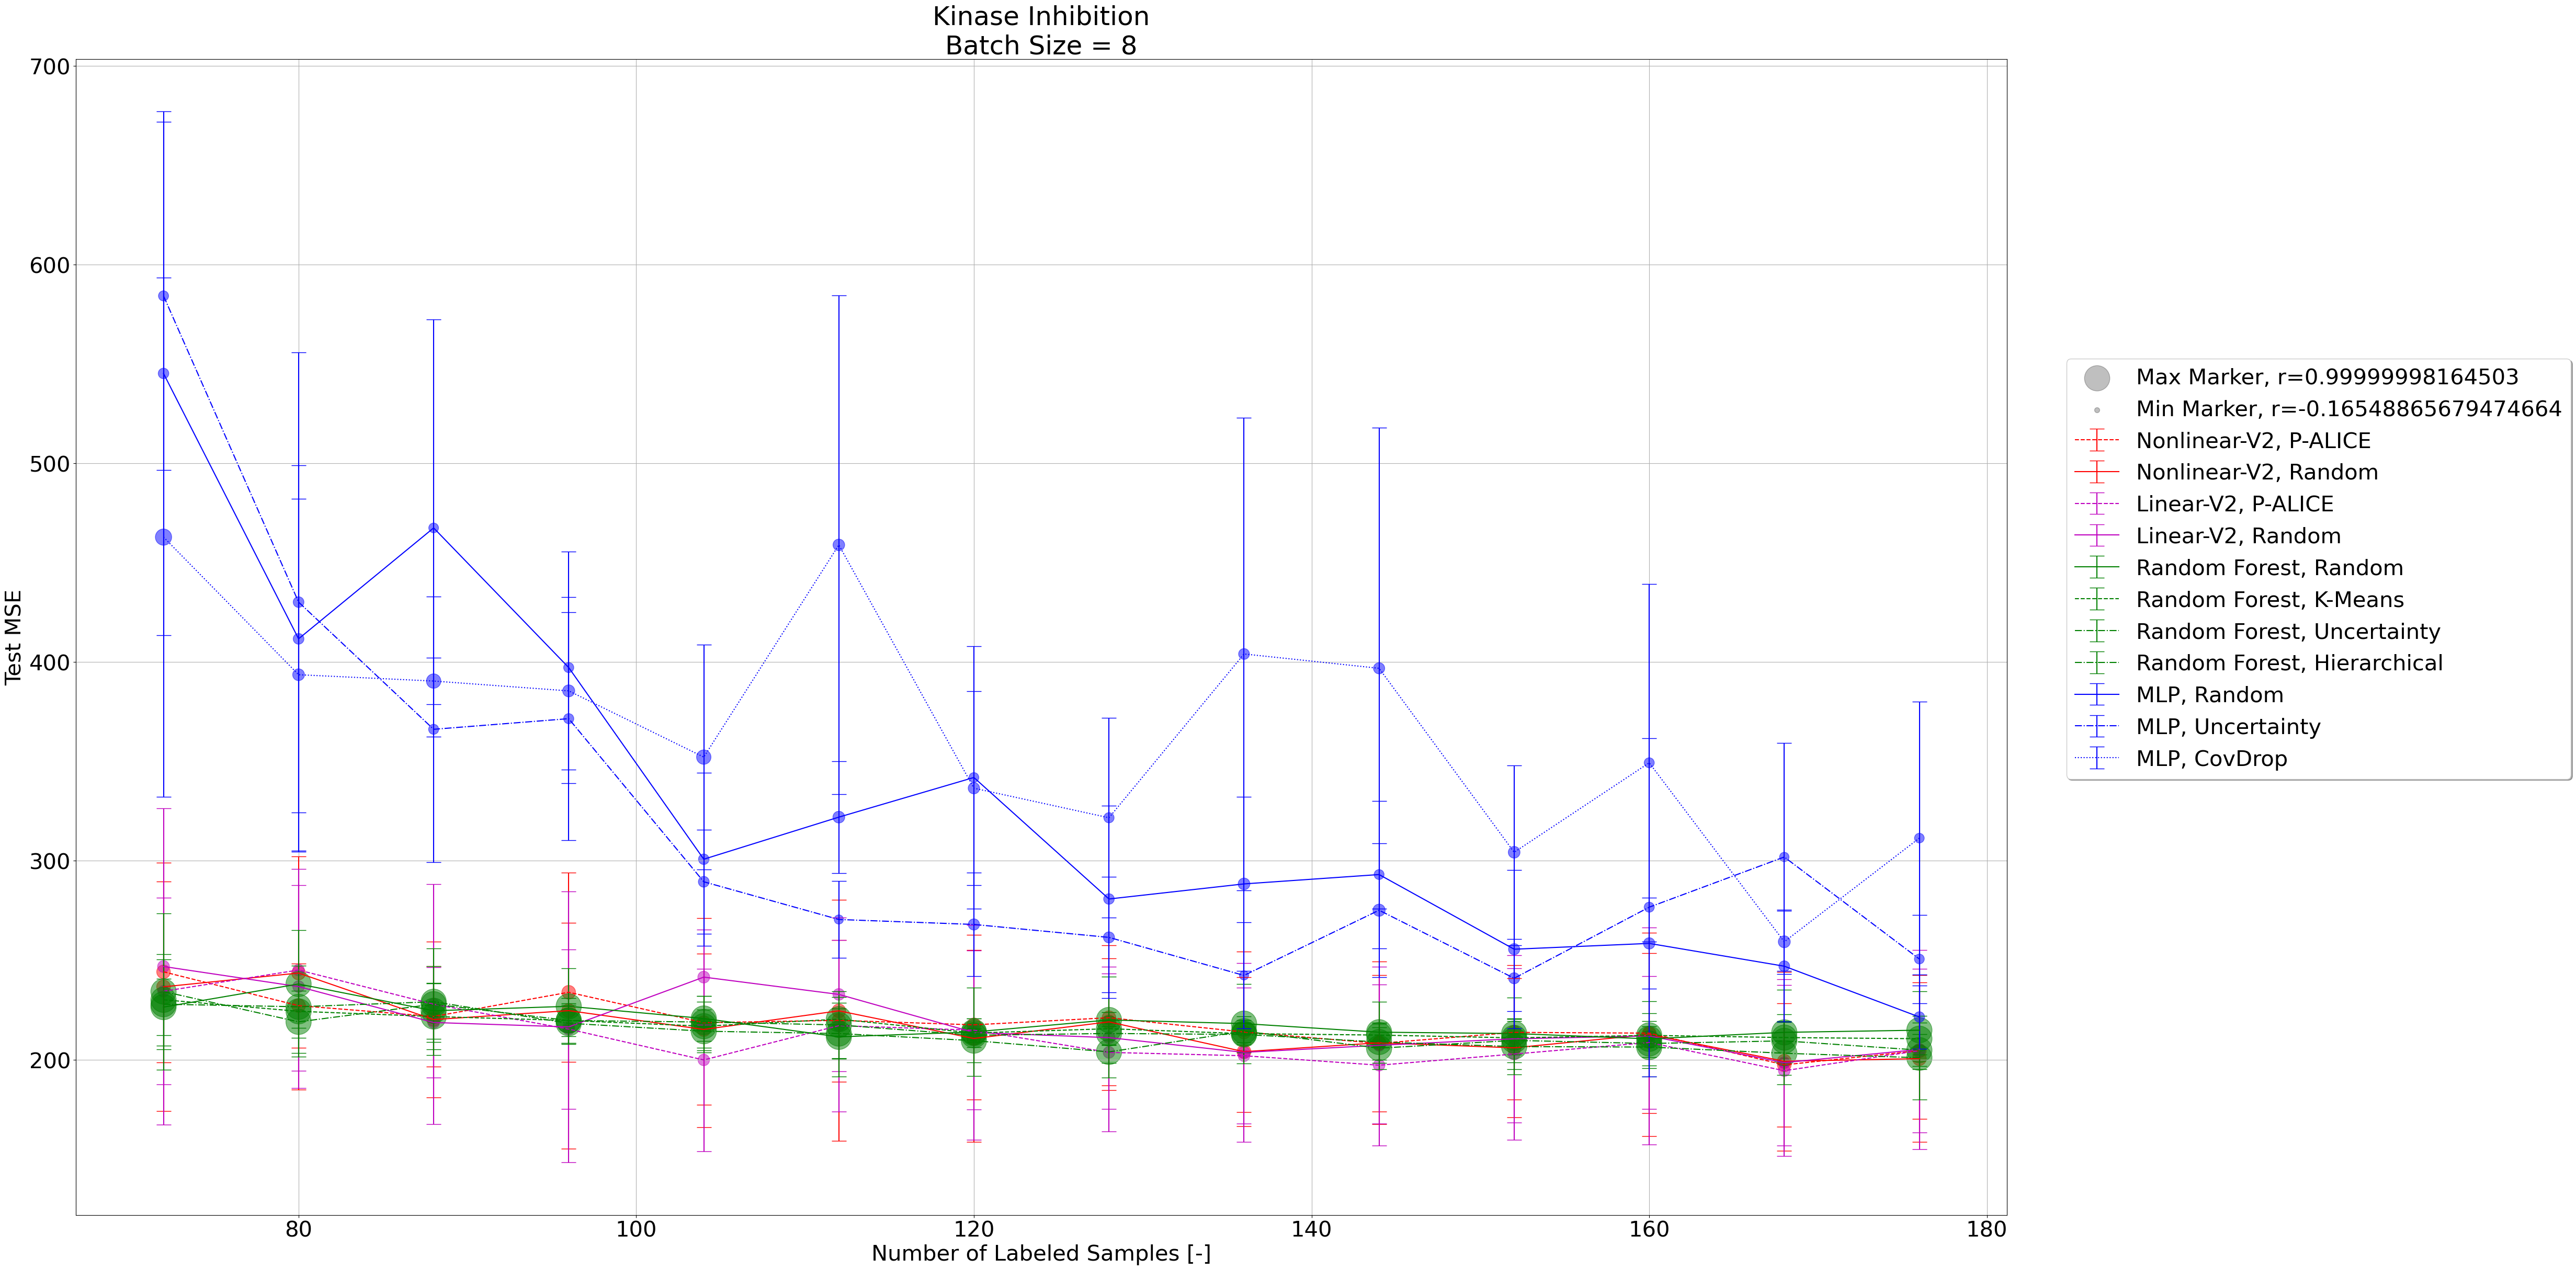

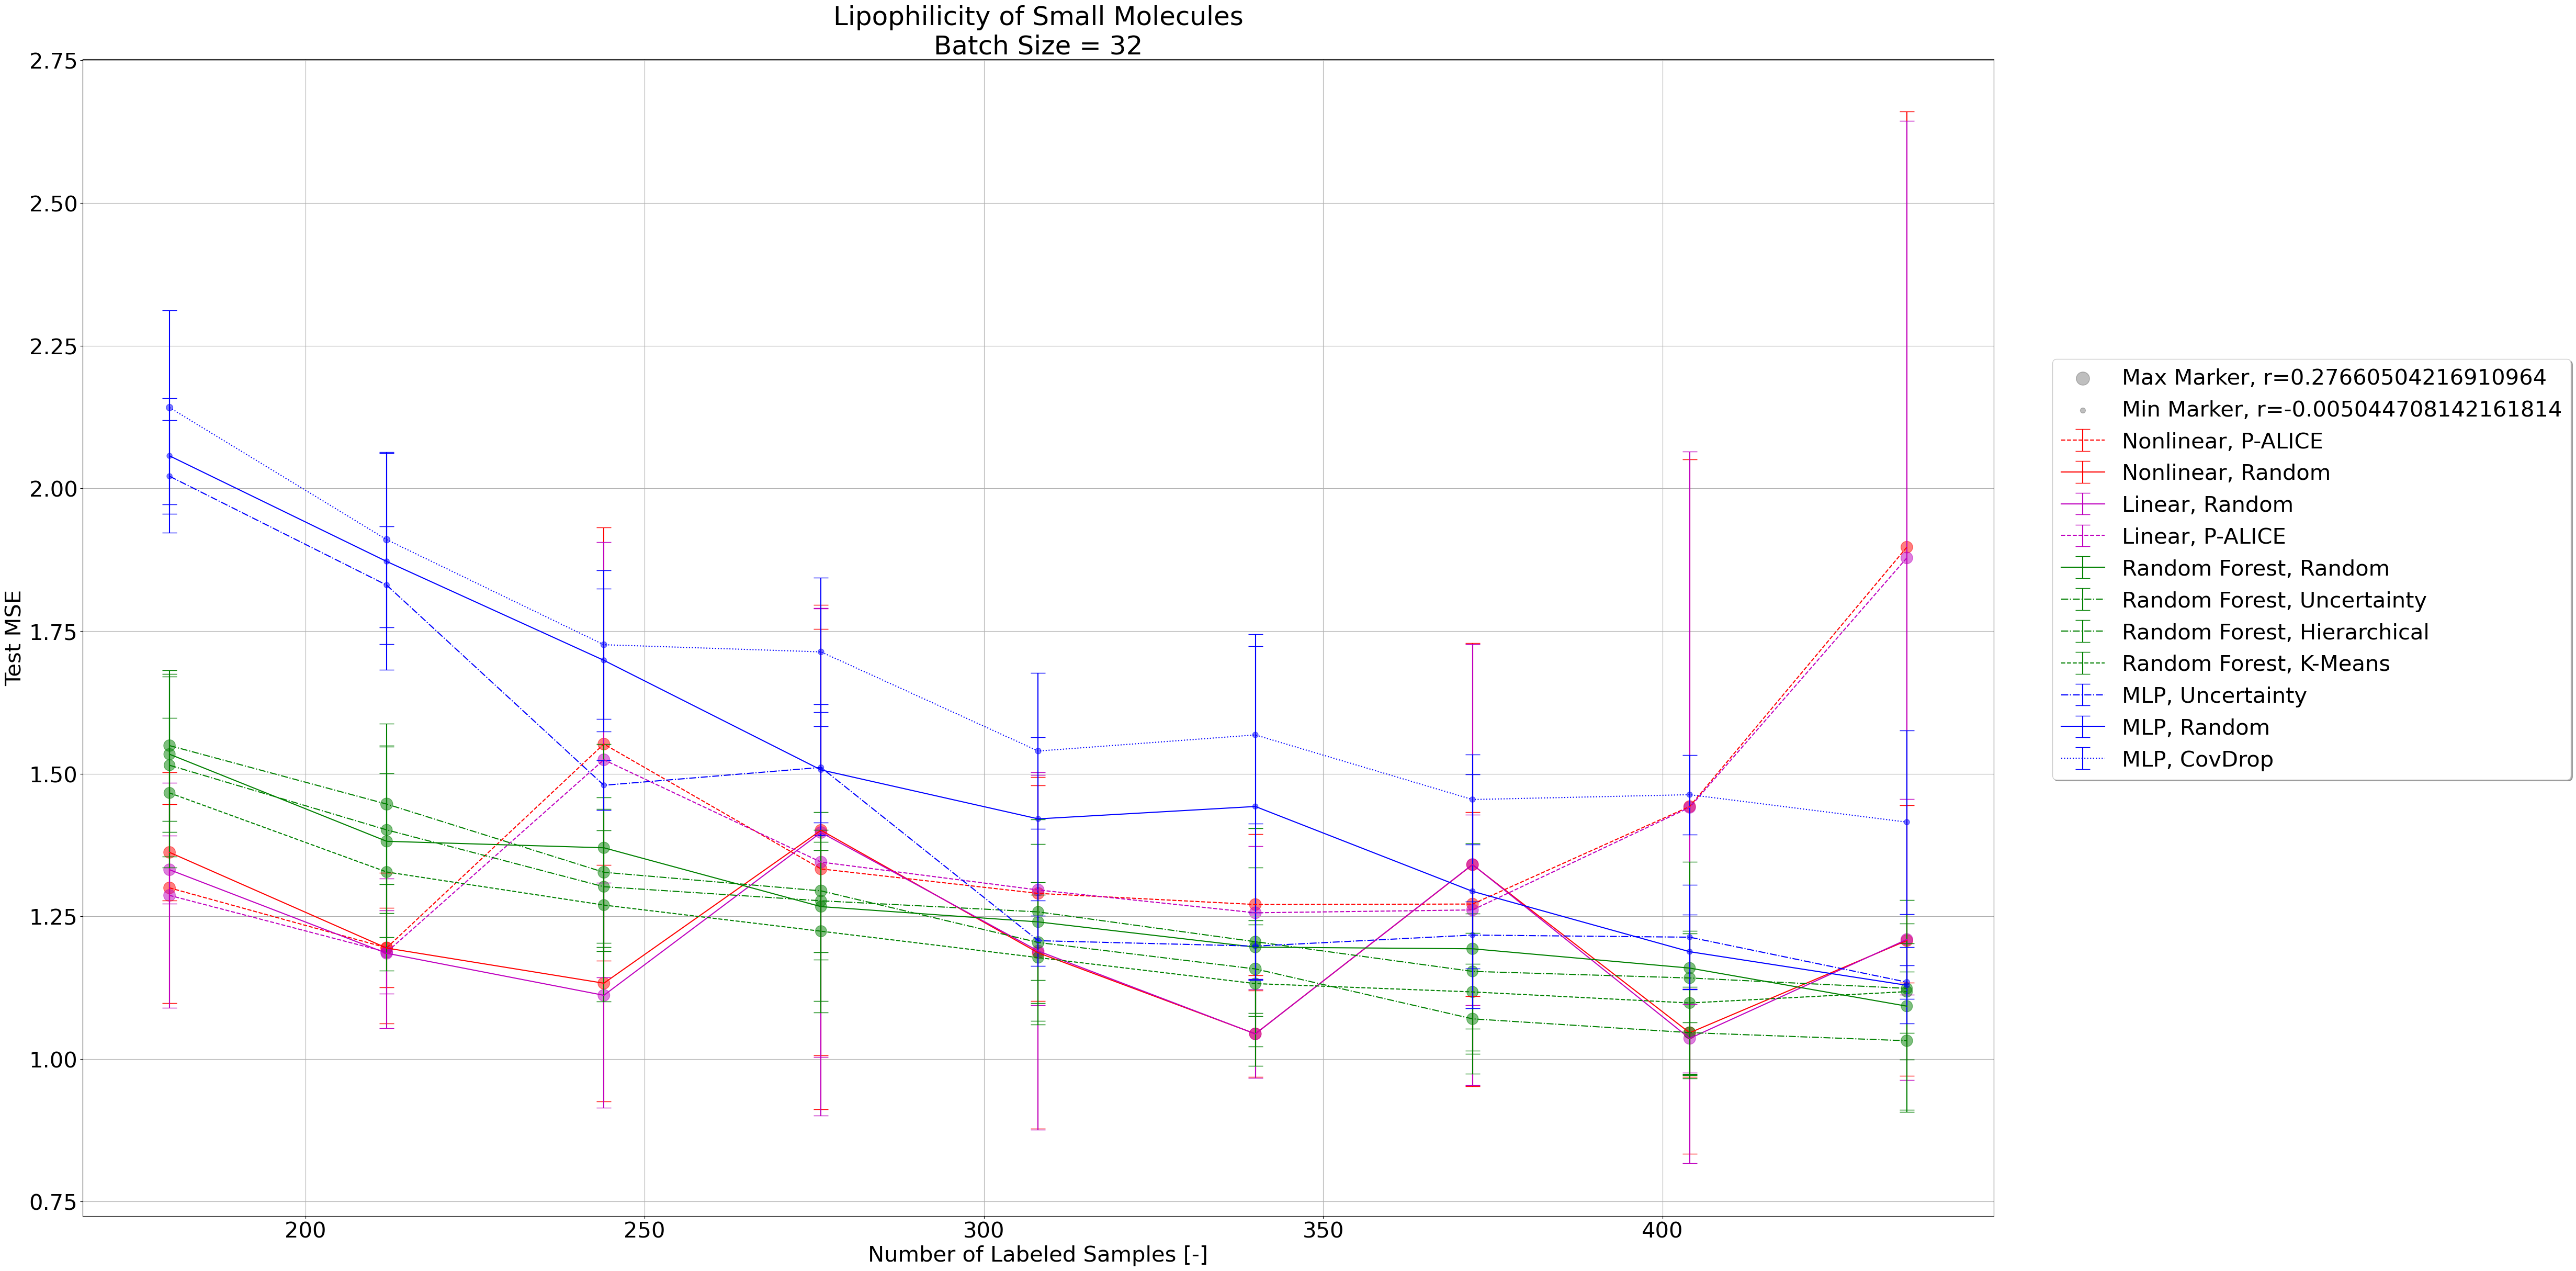

In [16]:
error_in_lengths_dict = {}

for target_dataset_name in all_dataset_names:
    error_in_lengths_dict[target_dataset_name] = plot_results_for_dataset(target_dataset_name,results_directory_list,x_axis_dict)

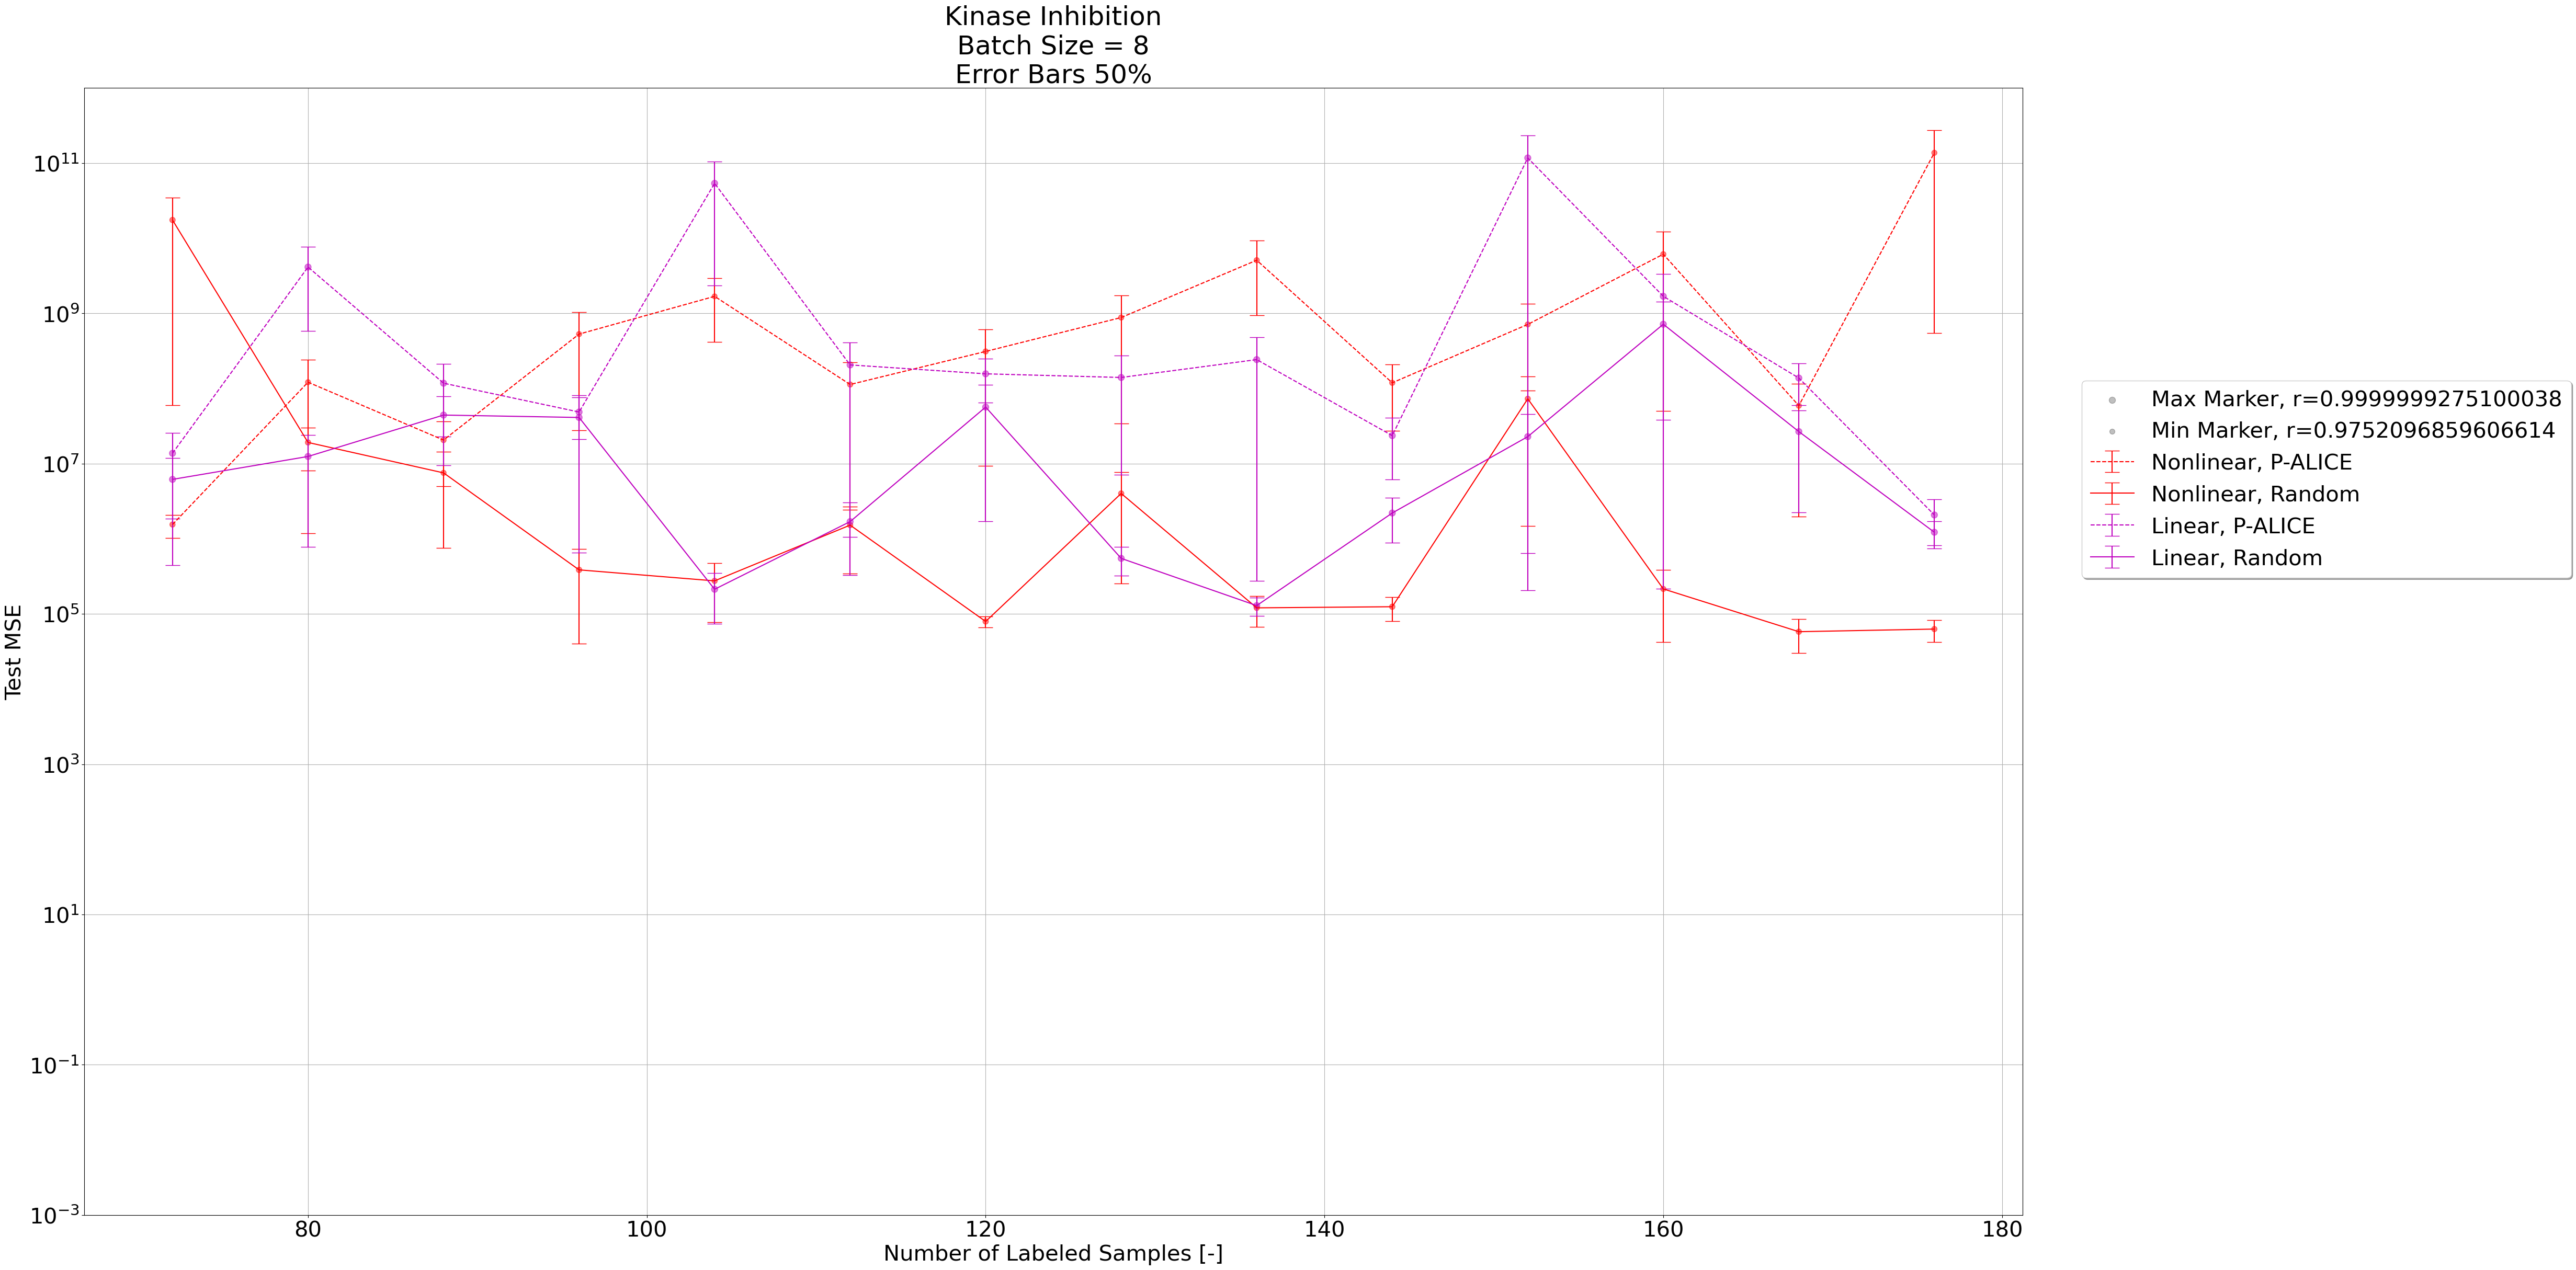

In [9]:
_ = plot_results_for_dataset("Inhibition_data", results_directory_list,x_axis_dict,regular_print=False)

In [10]:
check = []
for result in results_directory_list:
    if "Inhibition_data" in result and "linear" in result and "8" in result:
        check.append(result)
        result_array = np.load(result)
        print(result, f"mean={np.mean(result_array,axis=0)}\n")

Inhibition_data_linear_palice_8.npy mean=[1.37214728e+07 4.13280132e+09 1.17565305e+08 4.86127265e+07
 5.37433088e+10 2.05837700e+08 1.56717446e+08 1.40135151e+08
 2.42286636e+08 2.35865743e+07 1.17010304e+11 1.68647220e+09
 1.37802786e+08 2.07405202e+06]

Inhibition_data_nonlinearV2_random_8_cor.npy mean=[0.13903253 0.14356326 0.14170045 0.14674505 0.14789435 0.14488688
 0.14892412 0.14774478 0.14933338 0.14530708 0.14698379 0.1482975
 0.14767306 0.14573543]

Inhibition_data_linearV2_palice_8_cor.npy mean=[0.03346237 0.03622527 0.03583291 0.03897384 0.03628844 0.03856547
 0.04108525 0.04018636 0.04126036 0.04109134 0.03994171 0.04097063
 0.04020158 0.04186593]

Inhibition_data_linear_random_8_cor.npy mean=[0.99999992 0.99999991 0.99999992 0.99999992 0.99999991 0.99999992
 0.99999992 0.99999992 0.99999992 0.99999993 0.99999992 0.99999993
 0.99999992 0.99999993]

Inhibition_data_nonlinear_palice_8_cor.npy mean=[0.97977777 0.97697944 0.97938779 0.97881731 0.97520969 0.98044037
 0.9806426

In [11]:
check

['Inhibition_data_linear_palice_8.npy',
 'Inhibition_data_nonlinearV2_random_8_cor.npy',
 'Inhibition_data_linearV2_palice_8_cor.npy',
 'Inhibition_data_linear_random_8_cor.npy',
 'Inhibition_data_nonlinear_palice_8_cor.npy',
 'Inhibition_data_linearV2_palice_8.npy',
 'Inhibition_data_nonlinear_palice_8.npy',
 'Inhibition_data_nonlinear_random_8_cor.npy',
 'Inhibition_data_linearV2_random_8.npy',
 'Inhibition_data_nonlinearV2_palice_8.npy',
 'Inhibition_data_linear_palice_8_cor.npy',
 'Inhibition_data_linear_random_8.npy',
 'Inhibition_data_linearV2_random_8_cor.npy',
 'Inhibition_data_nonlinearV2_palice_8_cor.npy',
 'Inhibition_data_nonlinear_random_8.npy',
 'Inhibition_data_nonlinearV2_random_8.npy']

In [12]:
dummy1 = np.load('Inhibition_data_linearV2_palice_8.npy')

dummy2 = np.load('Inhibition_data_nonlinearV2_palice_8.npy')

In [13]:
if np.allclose(dummy1,dummy2,0,0) == True:
    print('These are the same')
else:
    print('These are different')

These are different


In [14]:
for file in results_directory_list:
    if 'cor' in file:
        print(file)
        dummy_cor_vals_all = np.load(file)
        dummy_cor_means = np.mean(dummy_cor_vals_all,axis=0)
        print(dummy_cor_means[::10])

Inhibition_data_randomforest_hierarchical_4_cor.npy
[0.99999986 0.99999986 0.99999989]
logd74_linear_random_16_cor.npy
[0.20523919 0.20660784]
logd74_nn_random_16_cor.npy
[-0.00258462 -0.00081862]
abalone_age_nn_uncertainty_32_cor.npy
[-0.01087053 -0.00689022 -0.01831877 -0.02617697]
logd74_linear_palice_32_cor.npy
[0.20726533]
abalone_age_randomforest_hierarchical_32_cor.npy
[0.4393377  0.44142295 0.41968817 0.44182026]
abalone_age_linear_random_32_cor.npy
[0.54474139 0.54606063 0.54370204 0.54447921]
logd74_linear_random_32_cor.npy
[0.20523919]
abalone_age_randomforest_random_16_cor.npy
[0.45565844 0.49944787 0.49342814 0.43429746 0.4629288  0.40804213
 0.41720246]
logd74_nn_covdrop_16_cor.npy
[0.0489589  0.00395521]
logd74_nonlinear_palice_16_cor.npy
[0.20726533 0.20755091]
Inhibition_data_randomforest_random_8_cor.npy
[0.99999993 0.99999988]
Inhibition_data_randomforest_random_4_cor.npy
[0.99999995 0.99999994 0.99999988]
logd74_nn_uncertainty_16_cor.npy
[ 0.002525   -0.00389203]
ab

[50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1050.0, 1100.0, 1150.0, 1200.0, 1250.0, 1300.0, 1350.0, 1400.0, 1450.0, 1500.0, 1550.0, 1600.0, 1650.0, 1700.0, 1750.0, 1800.0, 1850.0, 1900.0, 1950.0, 2000.0]


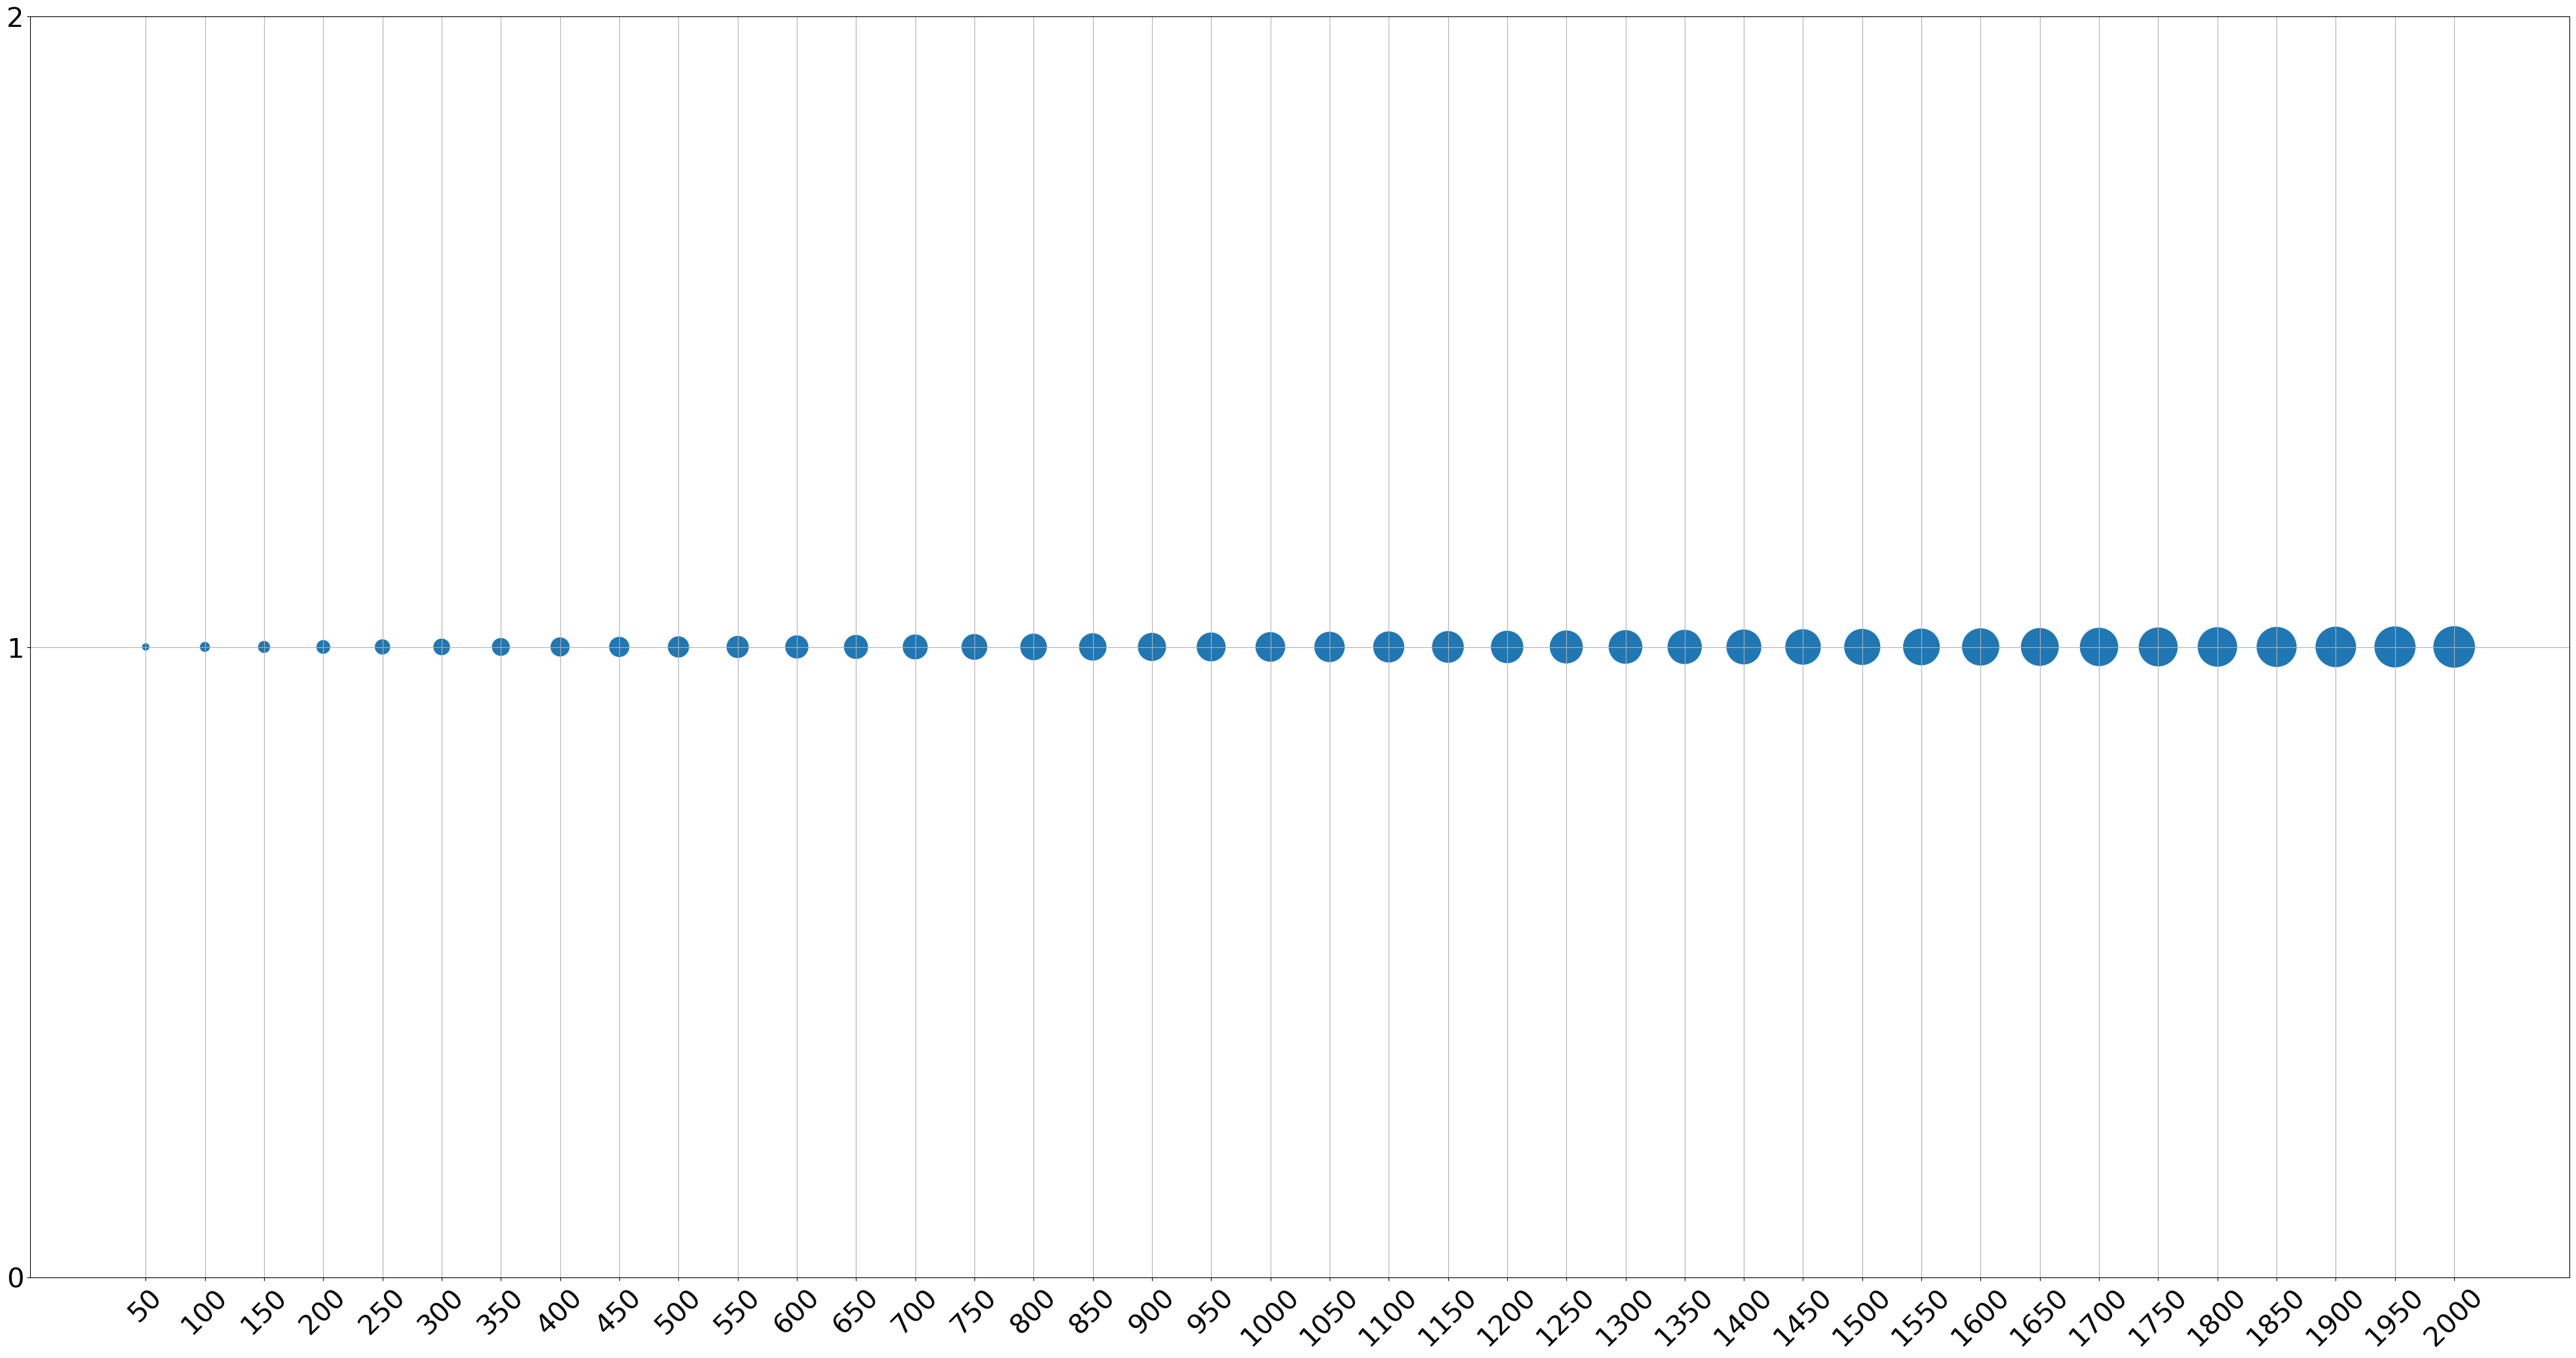

In [15]:
with plt.rc_context({'font.size': 30}):
    plt.figure(figsize=FIG_SIZE) 
    axis = np.arange(0.5,20.5,0.5)
    s = [i*100 for i in axis]
    print(s)
    plt.scatter(x=s,y=[1]*len(axis),s=s)
    plt.ylim([0,2])
    plt.yticks([0,1,2])
    plt.xticks(s,rotation=45)
    plt.grid()
    plt.show()